In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle

from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [ ]:
foldernames = os.listdir('/content/drive/MyDrive/raw-img')
categories = []
files = []
i = 0
for k, folder in enumerate(foldernames):
    filenames = os.listdir("/content/drive/MyDrive/raw-img/" + folder);
    for file in filenames:
        files.append("/content/drive/MyDrive/raw-img/" + folder + "/" + file)
        categories.append(k)

df = pd.DataFrame({
    'filename': files,
    'category': categories
})
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

<ipython-input-3-3f559299f8a0>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df[df.category == i].iloc[:500,:])
<ipython-input-3-3f559299f8a0>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df[df.category == i].iloc[:500,:])
<ipython-input-3-3f559299f8a0>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df[df.category == i].iloc[:500,:])
<ipython-input-3-3f559299f8a0>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df[df.category == i].iloc[:500,:])
<ipython-input-3-3f559299f8a0>:17: FutureWarning: The frame.append metho

,filename,category
0,/content/drive/MyDrive/raw-img/dog/OIP-sDVNHis...,0
1,/content/drive/MyDrive/raw-img/dog/OIP-m0hvV2L...,0
2,/content/drive/MyDrive/raw-img/dog/OIP-tjUYHhZ...,0
3,/content/drive/MyDrive/raw-img/dog/OIP-usA8Icn...,0
4,/content/drive/MyDrive/raw-img/dog/OIP-mtdnqll...,0
...,...,...
4995,/content/drive/MyDrive/raw-img/cow/OIP-wiHMBEz...,9
4996,/content/drive/MyDrive/raw-img/cow/OIP-aOiE-ro...,9
4997,/content/drive/MyDrive/raw-img/cow/OIP-YaqYGs5...,9
4998,/content/drive/MyDrive/raw-img/cow/OIP-zn22k4W...,9


In [ ]:
y = train_df['category']
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

In [ ]:
def centering_image(img):
    size = [256,256]

    img_size = img.shape[:2]

    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

<ipython-input-5-e89c06cb6672>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(train_df)) as pbar:


  0%|          | 0/5000 [00:00<?, ?it/s]

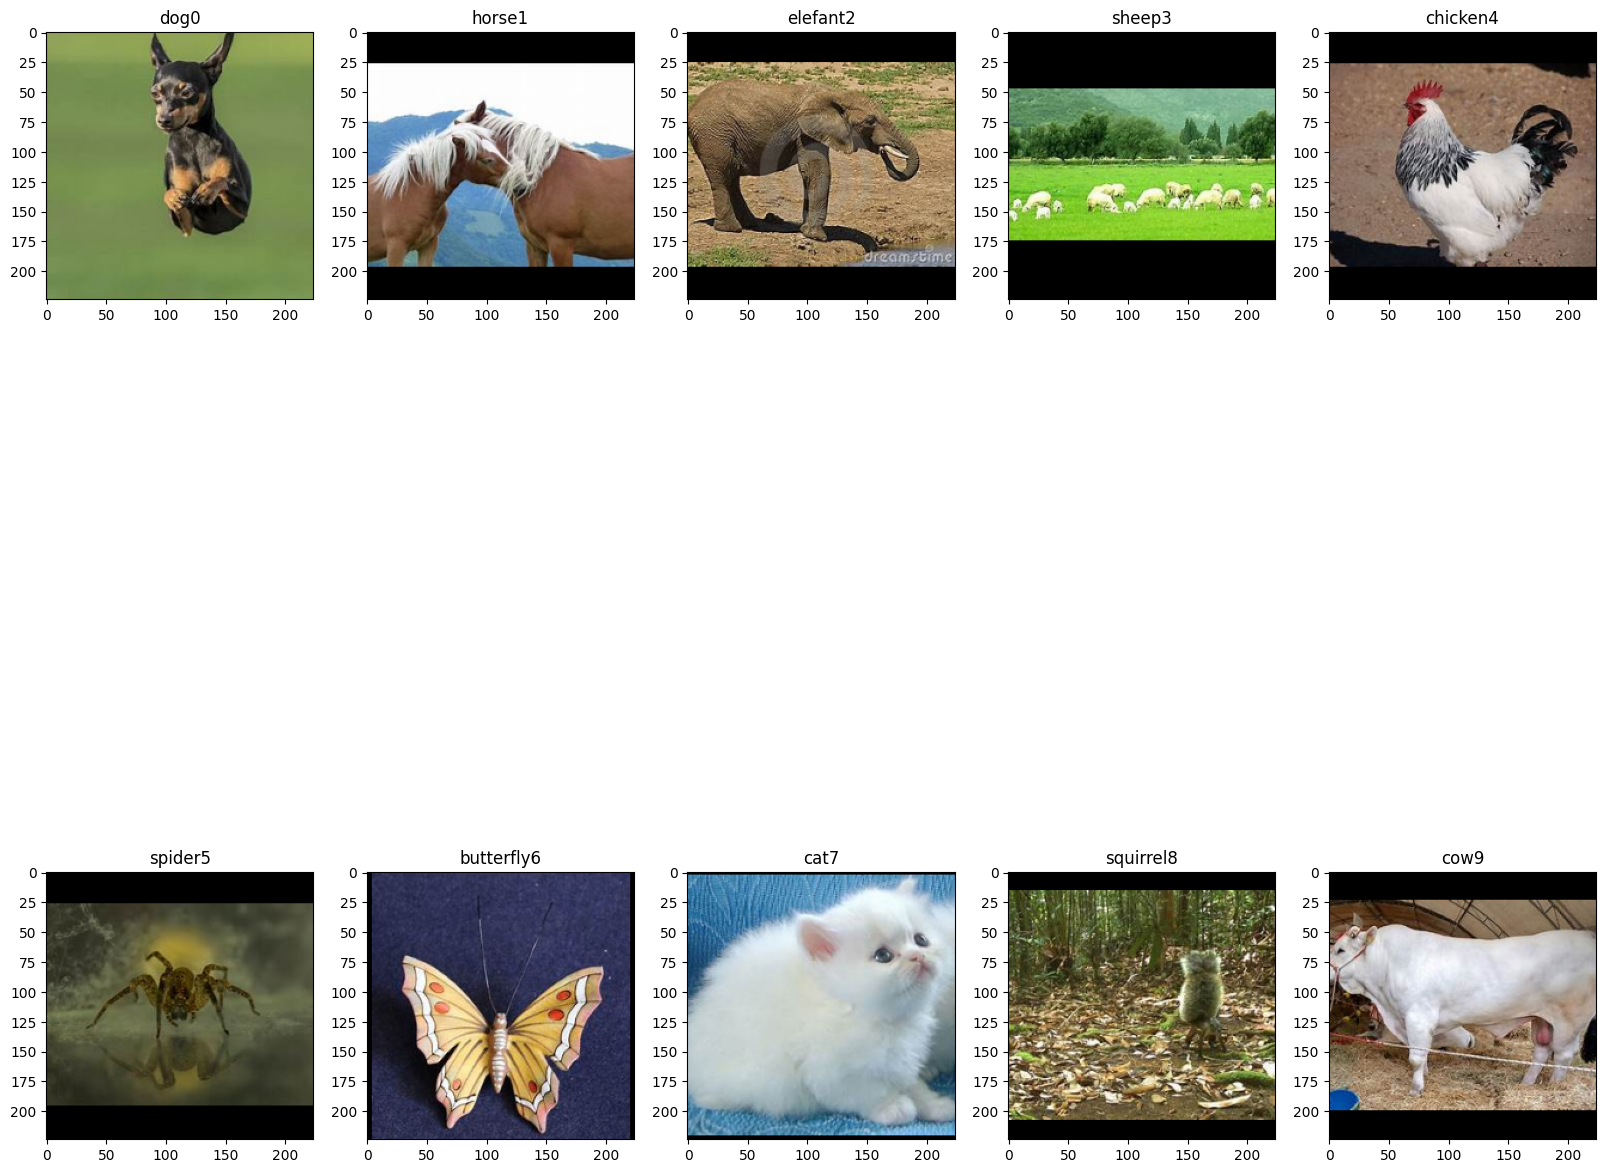

In [ ]:
rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[2]
#     image = cv2.imread(path[0])/
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [ ]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])

x = np.array(x_shuffle)
y = np.array(y_shuffle)
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows, img_cols, img_channel = 224, 224, 3
name_animal = ['dog','horse','elephant','sheep','chicken','spider','butterfly','cat','squirrel','cow']

x_train (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)


In [ ]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(10, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

58889256/58889256 [==============================] - 3s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
batch_size = 32
epochs = 30

train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')]
)

<ipython-input-9-987bb2c9f8ec>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
125/125 [==============================] - 96s 595ms/step - loss: 0.3044 - accuracy: 0.2575 - val_loss: 0.2074 - val_accuracy: 0.5450
Epoch 2/30
125/125 [==============================] - 70s 556ms/step - loss: 0.1445 - accuracy: 0.7163 - val_loss: 0.1266 - val_accuracy: 0.7220
Epoch 3/30
125/125 [==============================] - 71s 565ms/step - loss: 0.0974 - accuracy: 0.8180 - val_loss: 0.0748 - val_accuracy: 0.8590
Epoch 4/30
125/125 [==============================] - 70s 555ms/step - loss: 0.0679 - accuracy: 0.8823 - val_loss: 0.0660 - val_accuracy: 0.8930
Epoch 5/30
125/125 [==============================] - 70s 561ms/step - loss: 0.0564 - accuracy: 0.8990 - val_loss: 0.0621 - val_accuracy: 0.8990
Epoch 6/30
125/125 [==============================] - 70s 561ms/step - loss: 0.0428 - accuracy: 0.9305 - val_loss: 0.0518 - val_accuracy: 0.9140
Epoch 7/30
125/125 [==============================] - 70s 561ms/step - loss: 0.0395 - accuracy: 0.9342 - val_loss: 0.0503 - val_ac

In [ ]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))

CNN: Epochs=30, Train accuracy=0.99500, Validation accuracy=0.92800


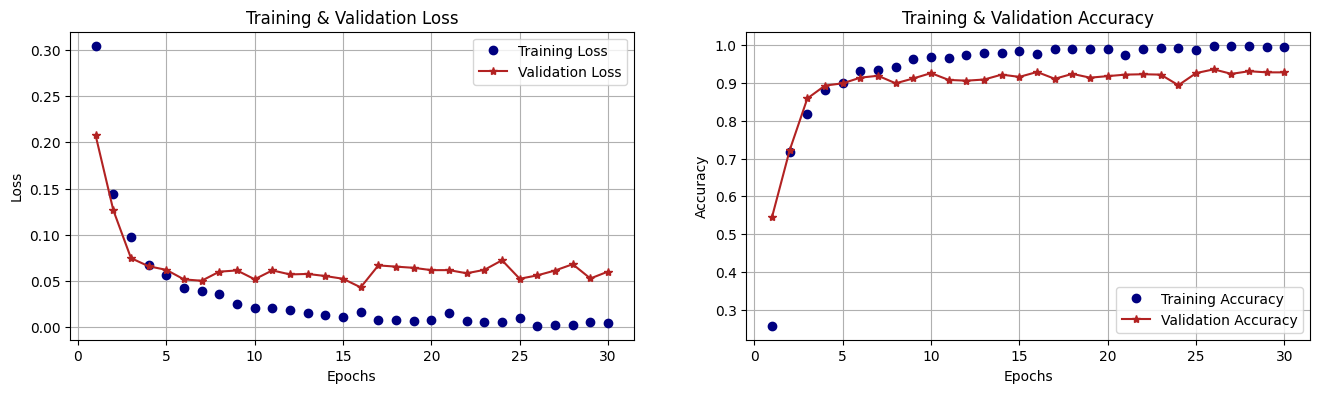

In [ ]:
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)

    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)

    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)

    plt.show()
    plt.close()

    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

1/1 [==============================] - 2s 2s/step


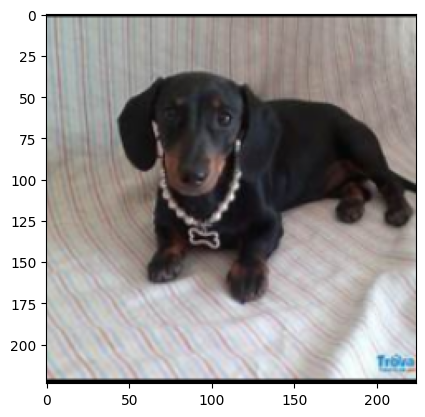

Actual  : dog
Predict : dog


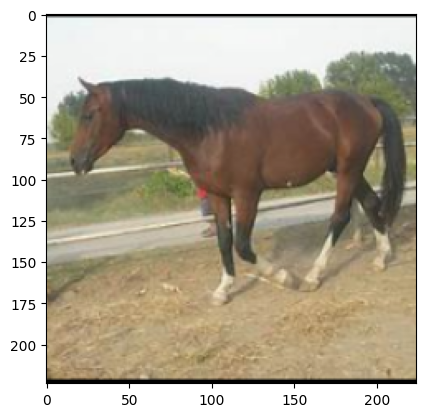

Actual  : horse
Predict : horse


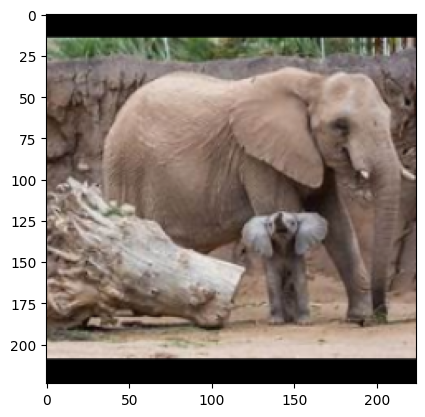

Actual  : elephant
Predict : dog


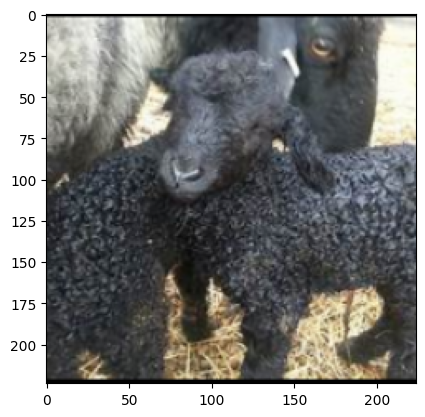

Actual  : sheep
Predict : sheep


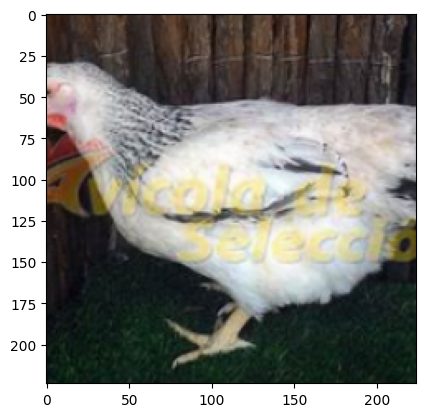

Actual  : chicken
Predict : chicken


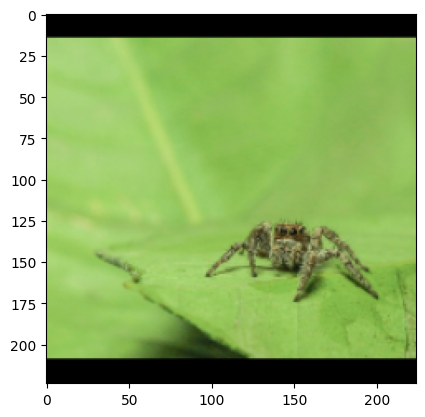

Actual  : spider
Predict : spider


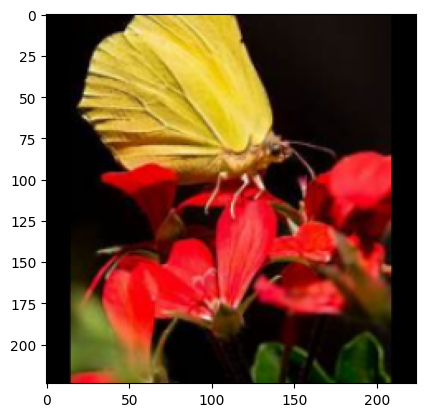

Actual  : butterfly
Predict : butterfly


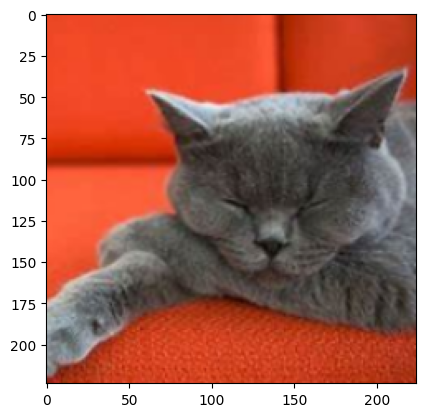

Actual  : cat
Predict : cat


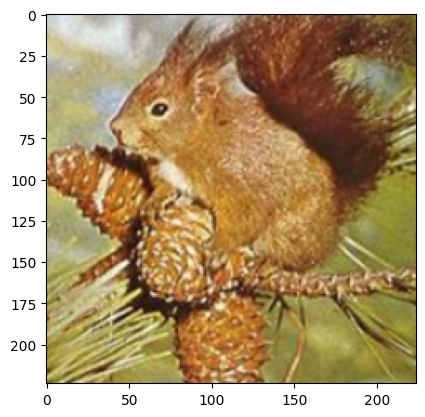

Actual  : squirrel
Predict : squirrel


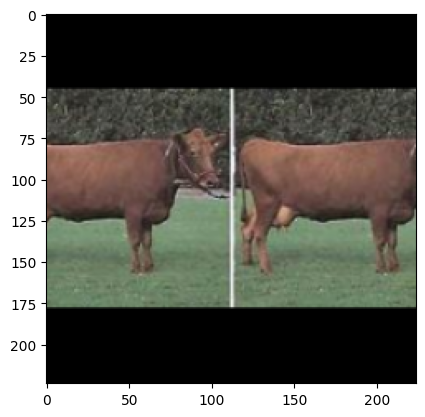

Actual  : cow
Predict : cow


In [ ]:
test_images = []
j = 39 # change this to get different images
for i in range(10):
    path = train_df[train_df.category == i].values[j]
    a = images[train_df[train_df.filename == path[0]].index[0]]
    img = np.array(a)
    img = img[:, :, ::-1].copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)
something = model.predict(test_images)
animals = name_animal
i = 0
for pred in something:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1